## Detecção de Fraude em Dados Financeiros: Aplicação de Oversampling, Classificação e K-Means para Identificação de Padrões

### Análise Exporatória dos dados

#### Contexto
Empresas de cartão de crédito precisam identificar transações fraudulentas para evitar cobranças indevidas.

#### Conteúdo
O conjunto de dados contém transações de cartões de crédito realizadas por portadores europeus em setembro de 2013. Ele inclui 492 fraudes de um total de 284.807 transações, sendo que as fraudes representam 0,172% do total. As variáveis de entrada são numéricas e resultam de uma transformação PCA, com exceção dos recursos 'Time' (tempo em segundos desde a primeira transação) e 'Amount' (valor da transação). A variável 'Class' indica se a transação é fraudulenta (1) ou não (0). Devido ao desequilíbrio de classes, recomenda-se usar a Área Sob a Curva de Precisão-Recall (AUPRC) para avaliar a precisão, em vez da matriz de confusão.

##### link para o conjunto de dados: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

#### Importando dados do Kaggle
Nessa parte, estamos fazendo o download do conjunto de dados para a realização das análises. O arquivo que contém o conjunto de dados se chama creditcard.csv. Também o carregamos em um dataframe para realizar uma análise exploratória mais aprofundada.

In [1]:
import kagglehub as kag 
import pandas as pd

In [2]:
path = kag.dataset_download("mlg-ulb/creditcardfraud")

In [3]:
file_csv = f"{path}/creditcard.csv"

#### Quais variáveis e sua quantidade?
Neste ponto, verificamos que o conjunto total possui 31 variáveis, sendo que três delas são conhecidas: Time (tempo em segundos desde a primeira transação), Amount (valor da transação) e Class (classe da observação, sendo [0] para não fraude e [1] para fraude). As variáveis de V1 até V28, conforme descrito no enunciado dos dados, são componentes de um PCA que foi aplicado aos dados antes de serem disponibilizados.

In [4]:
df = pd.read_csv(file_csv)

In [5]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [6]:
df.columns.shape[0]

31

#### Verificando o desbalanceamento dos dados
Ao verificarmos o nível de desbalanceamento, percebemos que existem 284.315 observações que representam transações do tipo "não fraude" e 492 transações do tipo "fraude". Em termos matemáticos, temos uma diferença de quantidade entre as classes de 283.823 para a classe "não fraude". Resumindo, temos um conjunto de dados muito desbalanceado, onde a classe "fraude" não é representativa em relação à classe "não fraude".

In [7]:
df_count_class = pd.DataFrame(df.Class.value_counts().reset_index())
df_count_class.columns = ['Classes', 'Frequência']
df_count_class

,Classes,Frequência
0,0,284315
1,1,492


#### Verificando a distribuição das classes "fraude" e "não fraude"
Visualizando as distribuições das classes "fraude" e "não fraude".



In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

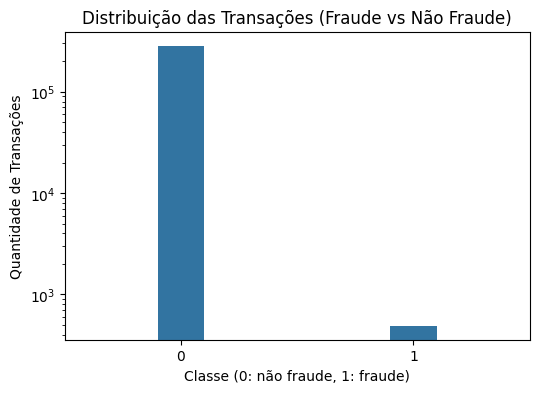

In [9]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df, width=0.2)
plt.title('Distribuição das Transações (Fraude vs Não Fraude)')
plt.xlabel('Classe (0: não fraude, 1: fraude)')
plt.ylabel('Quantidade de Transações')
plt.yscale('log')
plt.show()

#### Verificando a proporção entre as classes "fraude" e "não fraude"
Ao verificar a proporção de fraudes, vemos que o desbalanceamento é muito significativo, com aproximadamente 0,173%.

In [10]:
fraud_ratio = df[df.Class == 1].shape[0]/df[df.Class == 0].shape[0]
print(f'Proporção de fraudes: {fraud_ratio:.5f}')

Proporção de fraudes: 0.00173


#### Verificar a distribuição do valor das transações ('Amount') para fraudes e não fraudes
Ao interpretar os boxplots, observamos que a coluna 'Amount' tem uma distribuição com simetria para cada classe, visto que as medianas (segundo quartil) estão mais localizadas no centro das caixas. Observamos também valores discrepantes (outliers) acima do limite superior de detecção para ambas as classes.

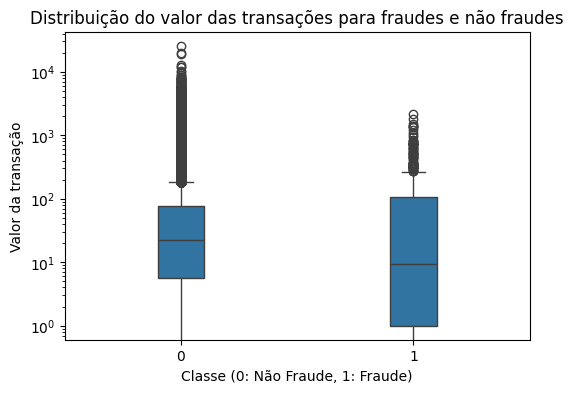

In [11]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='Class', y='Amount', data=df, width=0.2)
plt.title('Distribuição do valor das transações para fraudes e não fraudes')
plt.xlabel('Classe (0: Não Fraude, 1: Fraude)')
plt.ylabel('Valor da transação')
plt.yscale('log')
plt.show()

#### Identificando quantas observações na coluna ('Amount') de cada uma das classes fraudes e não fraudes são outliers

In [12]:
# Calculando os quartis e o IQR para a coluna 'Amount'
Q1 = df['Amount'].quantile(0.25)
Q3 = df['Amount'].quantile(0.75)
IQR = Q3 - Q1

# Definindo os limites superior e inferior para identificar outliers
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Identificando outliers para as fraudes
outliers_fraude = df[(df['Class'] == 1) & ((df['Amount'] < lower_limit) | (df['Amount'] > upper_limit))]

# Identificando outliers para as transações não fraudulentas
outliers_nao_fraude = df[(df['Class'] == 0) & ((df['Amount'] < lower_limit) | (df['Amount'] > upper_limit))]

# Exibindo os outliers encontrados
print(f"Outliers nas transações fraudulentas: {outliers_fraude.shape[0]}")
print(f"Outliers nas transações não fraudulentas: {outliers_nao_fraude.shape[0]}")

Outliers nas transações fraudulentas: 91
Outliers nas transações não fraudulentas: 31813


#### Distribuição do valor das transações nas classes fraudes e não fraudes em transações atípicas (outliers)
Ao analisar a distribuição abaixo, percebemos que, nas transações atípicas fraudulentas, os fraudadores sempre realizam transações com valores mais baixos, no intervalo de 0 a 2500 unidades. Nas transações legítimas, a distribuição é mais variada, com transações atípicas tanto altas quanto baixas. Um insight que podemos tirar é que os fraudadores, para não chamar a atenção, optam por realizar transações de valores baixos, seja de forma repetida ou não, de maneira frequente.

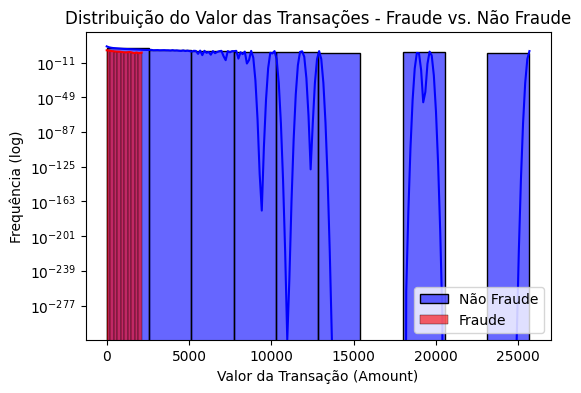

In [13]:
plt.figure(figsize=(6, 4))
sns.histplot(df[df['Class'] == 0]['Amount'], bins=10, color='blue', alpha=0.6, label='Não Fraude', kde=True)
sns.histplot(df[df['Class'] == 1]['Amount'], bins=10, color='red', alpha=0.6, label='Fraude', kde=True)
plt.yscale('log')
plt.xlabel('Valor da Transação (Amount)')
plt.ylabel('Frequência (log)')
plt.title('Distribuição do Valor das Transações - Fraude vs. Não Fraude')
plt.legend()
plt.show()

##### Analisando a plotagem abaixo, podemos tirar algumas conclusões:
A mediana de todas as transações classificadas como fraude tende a ter valores mais baixos.

O intervalo interquartil (IQR) das transações fraudulentas é maior do que o das transações não fraudulentas. Isso significa que há uma maior taxa de variação nas transações fraudulentas.

A cauda do IQR das transações fraudulentas é mais alta do que a das transações não fraudulentas. Isso indica que, embora as transações fraudulentas sejam quase sempre de valores baixos, podem ocorrer, em situações atípicas, transações com valores mais altos.



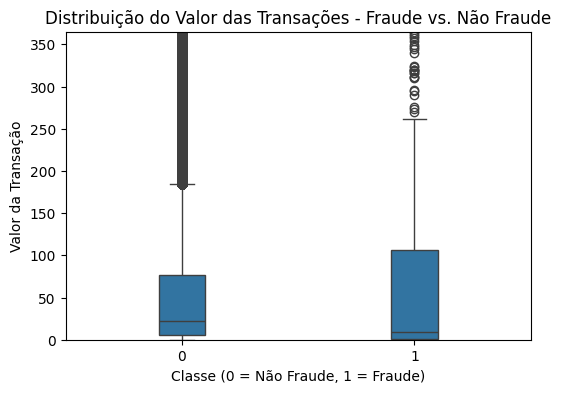

In [14]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=df['Class'], y=df['Amount'], width=0.2)
plt.ylim(0, df['Amount'].quantile(0.95))  # Limita o eixo Y para remover valores muito altos e facilitar a visualização
plt.title('Distribuição do Valor das Transações - Fraude vs. Não Fraude')
plt.xlabel('Classe (0 = Não Fraude, 1 = Fraude)')
plt.ylabel('Valor da Transação')
plt.show()

#### Verificar quantas fraudes ocorreram em valores realmente mais altos
Interpretando o resultado do código abaixo, observamos que, de fato, a maioria das fraudes ocorre em transações de valores mais baixos, enquanto as transações não fraudulentas estão bem distribuídas entre valores baixos e altos. Ou seja, de 100% das transações fraudulentas, apenas 8,73% são de valores acima do limite do percentil 95. Isso apenas reforça que, ao escolher entre realizar uma transação fraudulenta com valores altos ou baixos, os fraudadores tendem a realizar a maioria das transações com valores baixos, a fim de não levantar suspeitas. Somente em esporádicas ocasiões, quando buscam um golpe mais arriscado, optam por transações de valores mais altos, mas com grandes possibilidades de obter um lucro maior.

In [15]:
import numpy as np

# Definir o limite de valores altos (ex: 95º percentil das transações)
limite_alto = np.percentile(df['Amount'], 95)

# Contar fraudes acima do limite
fraudes_altas = df[(df['Class'] == 1) & (df['Amount'] > limite_alto)]
nao_fraudes_altas = df[(df['Class'] == 0) & (df['Amount'] > limite_alto)]

print(f"Total de fraudes acima do percentil 95: {len(fraudes_altas)}")
print(f"Total de transações não fraudulentas acima do percentil 95: {len(nao_fraudes_altas)}")

Total de fraudes acima do percentil 95: 43
Total de transações não fraudulentas acima do percentil 95: 14189


#### Comparando médias dos valores das transações fraudulentas e não fraudulentas
Como podemos ver, a média dos valores das transações fraudulentas é maior do que a das transações não fraudulentas. Como observamos anteriormente, a maioria das transações fraudulentas tem valores mais baixos, mas o valor das transações pode ser um fator relevante para identificar fraudes. No entanto, ele não pode ser utilizado como único critério. Vamos analisar mais à frente como essa informação se comporta por meio do cálculo da mediana.

In [16]:
# Calcular a média de Amount para fraudes e não fraudes
media_fraude = df[df['Class'] == 1]['Amount'].mean()
media_nao_fraude = df[df['Class'] == 0]['Amount'].mean()

print(f'Média de Amount para fraudes: {media_fraude:.2f}')
print(f'Média de Amount para não fraudes: {media_nao_fraude:.2f}')

Média de Amount para fraudes: 122.21
Média de Amount para não fraudes: 88.29


#### Comparando medianas dos valores das transações fraudulentas e não fraudulentas
Agora ficou interessante! Vemos que o comportamento da mediana confirma o que estávamos falando acima: a maioria das transações fraudulentas tem valores baixos. O cálculo da média, por outro lado, mostrou o contrário, justamente porque algumas transações fraudulentas têm valores altos, o que acaba puxando a média para cima.

In [17]:
# Calcular a mediana de Amount para fraudes e não fraudes
media_fraude = df[df['Class'] == 1]['Amount'].median()
media_nao_fraude = df[df['Class'] == 0]['Amount'].median()

print(f'Mediana de Amount para fraudes: {media_fraude:.2f}')
print(f'Mediana de Amount para não fraudes: {media_nao_fraude:.2f}')

Mediana de Amount para fraudes: 9.25
Mediana de Amount para não fraudes: 22.00


#### Analisando a dispersão dos valores das transações fraudulentas e não fraudulentas
Analisando o gráfico abaixo, vemos que existem mais pontos densos nas transações não fraudulentas do que nas fraudulentas. Como há mais transações não fraudulentas, os valores dessas transações acabam se espalhando por toda a faixa de valores. Já nas transações fraudulentas, há menos pontos e menor densidade. Isso significa que as fraudes seguem um padrão mais específico de valores, ou seja, confirma o que estamos observando sobre valores baixos na maioria das transações fraudulentas.

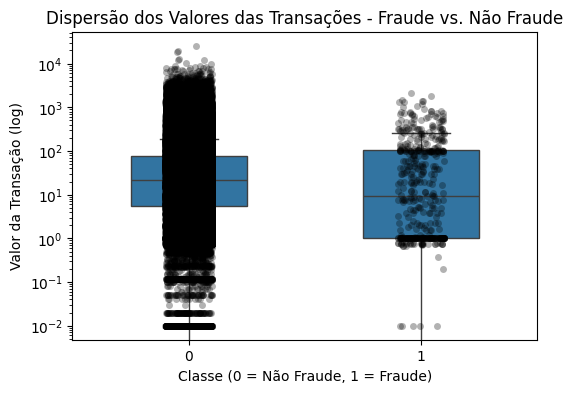

In [18]:
plt.figure(figsize=(6, 4))

# Criando o boxplot + stripplot para visualizar melhor os outliers
sns.boxplot(x='Class', y='Amount', data=df, showfliers=False, width=0.5)
sns.stripplot(x='Class', y='Amount', data=df, jitter=True, alpha=0.3, color='black')

plt.yscale('log')  # Escala logarítmica para melhor visualização
plt.xlabel('Classe (0 = Não Fraude, 1 = Fraude)')
plt.ylabel('Valor da Transação (log)')
plt.title('Dispersão dos Valores das Transações - Fraude vs. Não Fraude')

plt.show()

#### Verificando se há uma correlação linear forte entre as variáveis dependentes e a variável classe
Analisando a correlação abaixo, vemos que não existe nenhuma variável com correlação forte com a variável classe, ou seja, todas apresentam correlações baixas. Isso significa que o modelo de regressão logística, apesar de ser um modelo que pode funcionar para um problema dessa natureza (binário), pode não conseguir aprender de forma eficaz a identificar as fraudes, justamente porque não há uma correlação linear forte entre as variáveis dependentes e a variável classe. Diante desse cenário, além da regressão logística, utilizaremos modelos como XGBoost e RandomForest, visto que esses dois últimos podem se adaptar melhor a esse conjunto de dados e capturar as fraudes com mais eficácia.

In [19]:
# Verifique a correlação entre as variáveis independentes e a variável dependente
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None)

# Ajustando a largura da tabela
corr.style.set_table_attributes('style="width: 70%;"').background_gradient(cmap='coolwarm', axis=None)

# Ajustando o tamanho da fonte e outras configurações
corr.style.set_table_styles(
    [{'selector': 'th', 'props': [('font-size', '10px')]},  # Tamanho da fonte das colunas
     {'selector': 'td', 'props': [('font-size', '9px')]}   # Tamanho da fonte das células
]).background_gradient(cmap='coolwarm', axis=None)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.000000,0.117396,-0.010593,-0.419618,-0.105260,0.173072,-0.063016,0.084714,-0.036949,-0.008660,0.030617,-0.247689,0.124348,-0.065902,-0.098757,-0.183453,0.011903,-0.073297,0.090438,0.028975,-0.050866,0.044736,0.144059,0.051142,-0.016182,-0.233083,-0.041407,-0.005135,-0.009413,-0.010596,-0.012323
V1,0.117396,1.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.227709,-0.101347
V2,-0.010593,0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.531409,0.091289
V3,-0.419618,-0.000000,0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.210880,-0.192961
V4,-0.105260,-0.000000,-0.000000,0.000000,1.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.098732,0.133447
V5,0.173072,0.000000,0.000000,-0.000000,-0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.386356,-0.094974
V6,-0.063016,-0.000000,0.000000,0.000000,-0.000000,0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.215981,-0.043643
V7,0.084714,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.397311,-0.187257
V8,-0.036949,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.103079,0.019875
V9,-0.008660,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.044246,-0.097733


### Preparação dos dados para o modelo

#### Verificando a existência de dados faltantes

É verificado que o conjunto de dados não possui dados faltantes

In [20]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

#### Verificando se existem variáveis categóricas

O conjunto de dados não possui atributos do tipo categórico

In [21]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

#### Retirando a variável Tempo

In [22]:
# Tentar dropar a coluna 'Time', ignorando o erro se a coluna não existir
df.drop('Time', axis=1, errors='ignore', inplace=True)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### Tratamento dos outliers
Como temos um conjunto de dados altamente desbalanceado, optamos por manter os outliers, visto que estamos tratando da identificação de fraudes e, pelas nossas análises, as fraudes também podem assumir a forma de transações atípicas. Retirá-los seria impedir que o modelo tentasse aprender sobre essas transações.

#### Aplicação de técnicas de balanceamento
Nosso conjunto de dados é bastante desbalanceado. Podemos até adotar técnicas de adicionar pesos maiores às observações da classe minoritária, porém, como a diferença entre as classes é muito grande, utilizaremos técnicas de balanceamento de dados já aplicadas na literatura. Como queremos identificar fraudes e a amostra de observações fraudulentas é extremamente menor, iremos aumentar a quantidade de amostras fraudulentas para melhorar a capacidade do modelo em identificá-las. Utilizaremos o Oversampling para as fraudes.

In [23]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import warnings

# Suprimir o aviso específico
warnings.filterwarnings("ignore", category=FutureWarning)

X = df.drop('Class', axis=1)  # Variáveis independentes
y = df['Class']  # Variável alvo (fraude ou não fraude)

smote = SMOTE(sampling_strategy='auto', random_state=42)
ovs_X, ovs_y = smote.fit_resample(X, y)

print('X', ovs_X.shape)
print('y', ovs_y.shape)

X (568630, 29)
y (568630,)


#### Verificando a importância das variáveis
Ao analisar o gráfico abaixo, vemos que as três variáveis mais importantes do conjunto de dados extraídas através do PCA são, na ordem, V10, V4 e V14. Iremos, mais à frente, testá-las nos modelos e avaliar o seu nível de representatividade.

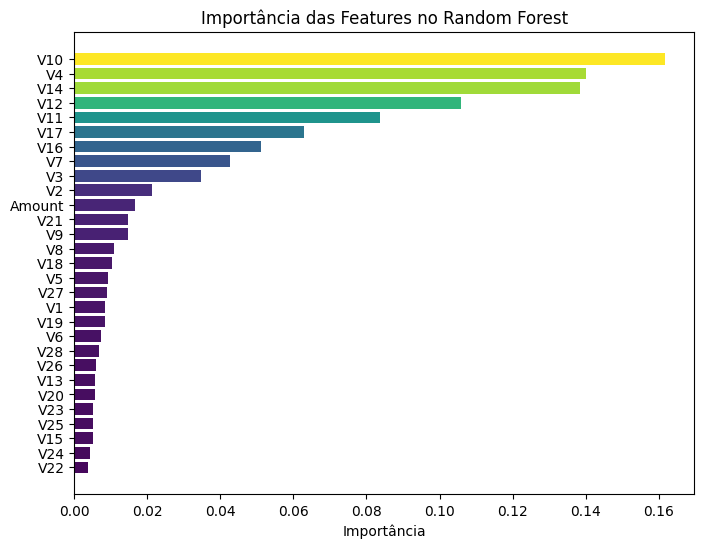

In [24]:
from sklearn.ensemble import RandomForestClassifier

# Pegar apenas 10% do conjunto de dados
X_train, X_test, y_train, y_test = train_test_split(ovs_X, ovs_y, test_size=0.9, random_state=42)

# Criar e treinar o modelo RandomForest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Obter a importância das features
feature_importance = rf.feature_importances_

# Criar um DataFrame para visualizar
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

# Ordenar as features pela sua importância
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotando o gráfico de barras com colormap
plt.figure(figsize=(8, 6))

# Usando um colormap 'viridis' que vai de cores mais frias (menos importantes) para mais quentes (mais importantes)
plt.barh(importance_df['Feature'], importance_df['Importance'], color=plt.cm.viridis(importance_df['Importance'] / max(importance_df['Importance'])))

plt.xlabel('Importância')
plt.title('Importância das Features no Random Forest')
plt.gca().invert_yaxis()  # Inverter o gráfico para as barras mais importantes ficarem no topo
plt.show()

#### Clusterizando o conjunto de dados após o Oversampling com as features mais importantes
Ao realizar a clusterização com as features mais importantes após o balanceamento, podemos perceber que é possível obter uma boa margem de separação dos dados entre as classes de fraude e não fraude. Isso significa que o conjunto de dados está mais adequado para ser trabalhado em modelos supervisionados, como veremos mais à frente.

Obs: utilizamos apenas as duas features mais importantes para possibilitar uma visualização em um espaço 2D dos clusters.

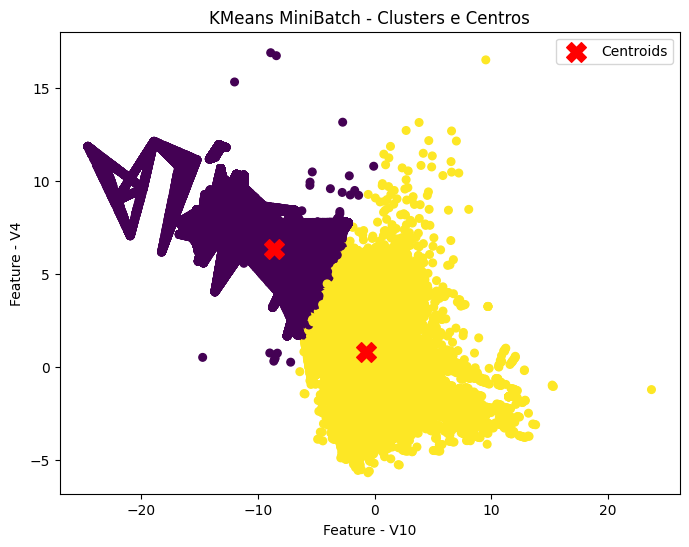

In [27]:
from sklearn.cluster import MiniBatchKMeans

#Gerando o conjunto de dados com a features mais importantes
X_cluster = ovs_X[['V10', 'V4']]
X_cluster

# Definir o número de clusters (por exemplo, k=2)
kmeans = MiniBatchKMeans(n_clusters=2, random_state=42)

# Ajustar o modelo aos dados (as duas colunas do DataFrame)
kmeans.fit(X_cluster)

# Obter os rótulos de cluster atribuídos a cada ponto
labels = kmeans.labels_

# Obter as coordenadas dos centros dos clusters
centroids = kmeans.cluster_centers_

# Plotar os dados e os clusters
plt.figure(figsize=(8, 6))

# Plotar os pontos de dados com base nos rótulos de clusters
plt.scatter(X_cluster['V10'], X_cluster['V4'], c=labels, cmap='viridis', s=30, marker='o')

# Plotar os centros dos clusters
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroids')

# Adicionar rótulos e título
plt.title('KMeans MiniBatch - Clusters e Centros')
plt.xlabel('Feature - V10')
plt.ylabel('Feature - V4')

# Mostrar a legenda
plt.legend()

# Exibir o gráfico
plt.show()

#### Aplicando normalização nos dados

In [26]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled_superv = scaler.fit_transform(ovs_X)  # X é o conjunto de variáveis independentes

#### Treinamento análise dos resultados para os modelos

##### Definindo funções

In [33]:
def cross_validation(model, X_train, y_train, folds):

    # Definindo múltiplas métricas
    scoring = ['accuracy', 'precision', 'recall', 'f1']

    # Aplicando validação cruzada
    # cv=5 significa que estamos usando 10 folds
    scores = cross_validate(model, X_train, y_train, cv=folds, scoring=scoring)
    
    # Exibindo as pontuações de cada métrica
    print(f'Pontuação de accuracy em cada fold: {scores["test_accuracy"]}')
    print(f'Pontuação de precision em cada fold: {scores["test_precision"]}')
    print(f'Pontuação de recall em cada fold: {scores["test_recall"]}')
    print(f'Pontuação de f1 em cada fold: {scores["test_f1"]}')
    
    # Média e desvio padrão das pontuações
    print(f'Média da pontuação de accuracy: {scores["test_accuracy"].mean()}')
    print(f'Desvio padrão de accuracy: {scores["test_accuracy"].std()}')
    
    print(f'Média da pontuação de precision: {scores["test_precision"].mean()}')
    print(f'Desvio padrão de precision: {scores["test_precision"].std()}')
    
    print(f'Média da pontuação de recall: {scores["test_recall"].mean()}')
    print(f'Desvio padrão de recall: {scores["test_recall"].std()}')
    
    print(f'Média da pontuação de f1: {scores["test_f1"].mean()}')
    print(f'Desvio padrão de f1: {scores["test_f1"].std()}')

##### Dividindo o conjunto de dados em treino e teste (O tetse não será usado pq estaremos usando validação cruzada)

In [38]:
# Dividindo em treino e teste (não será usado o teste na validação cruzada)
X_train, X_test, y_train, y_test = train_test_split(X_scaled_superv, ovs_y, test_size=0.2, random_state=42)

##### Testando o modelo LogisticRegression

In [39]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Criando o modelo
model = LogisticRegression(max_iter=1000)
cross_validation(model, X_train, y_train, 5)

Pontuação de accuracy em cada fold: [0.95696904 0.95678219 0.95568305 0.95627659 0.95493515]
Pontuação de precision em cada fold: [0.983478   0.98163265 0.98206059 0.98259899 0.98198681]
Pontuação de recall em cada fold: [0.92951086 0.93094044 0.92827923 0.92896103 0.92682605]
Pontuação de f1 em cada fold: [0.9557332  0.95561476 0.95441286 0.95502747 0.95360941]
Média da pontuação de accuracy: 0.9561292026580288
Desvio padrão de accuracy: 0.0007454178482925157
Média da pontuação de precision: 0.9823514072504661
Desvio padrão de precision: 0.0006425908376769896
Média da pontuação de recall: 0.9289035225919312
Desvio padrão de recall: 0.0013584436939983193
Média da pontuação de f1: 0.954879540899985
Desvio padrão de f1: 0.0007902115502692137


##### Testando o modelo XGBoost

In [41]:
import xgboost as xgb

# Criar o modelo XGBoost com os paramêtros mais utlizados na maioria dos problemas de classificação
model = xgb.XGBClassifier(
    n_estimators=100,          # Número de árvores
    learning_rate=0.1,         # Taxa de aprendizado
    max_depth=5,               # Profundidade máxima das árvores
    min_child_weight=3,        # Peso mínimo de uma folha
    subsample=0.8,             # Subamostragem
    colsample_bytree=0.9,      # Fração das colunas usadas para cada árvore
    gamma=0,                   # Redução mínima da perda
    objective='binary:logistic', # Função de perda para classificação binária
    eval_metric='logloss',     # Métrica de avaliação
)

cross_validation(model, X_train, y_train, 5)

Pontuação de accuracy em cada fold: [0.99647179 0.9969664  0.99638386 0.99670261 0.99684546]
Pontuação de precision em cada fold: [0.99580487 0.99604847 0.99556463 0.99608997 0.99678923]
Pontuação de recall em cada fold: [0.99714085 0.99788862 0.99720683 0.99731679 0.99689885]
Pontuação de f1 em cada fold: [0.99647241 0.9969677  0.99638505 0.99670301 0.99684404]
Média da pontuação de accuracy: 0.9966740239071028
Desvio padrão de accuracy: 0.00021944667719275826
Média da pontuação de precision: 0.9960594364754549
Desvio padrão de precision: 0.00041068020664048865
Média da pontuação de recall: 0.9972903883999724
Desvio padrão de recall: 0.00032900826157164015
Média da pontuação de f1: 0.9966744416221127
Desvio padrão de f1: 0.00021915363802170194


##### Testando o modelo RandomForest

In [44]:
from sklearn.ensemble import RandomForestClassifier

# Criando o modelo de RandomForest
model = RandomForestClassifier(n_estimators=50, random_state=42)
cross_validation(model, X_train, y_train, 5)

Pontuação de accuracy em cada fold: [0.9998791  0.99991207 0.9998681  0.99992306 0.9998681 ]
Pontuação de precision em cada fold: [0.99975813 0.99982408 0.99973615 0.99984607 0.99973614]
Pontuação de recall em cada fold: [1. 1. 1. 1. 1.]
Pontuação de f1 em cada fold: [0.99987905 0.99991203 0.99986806 0.99992303 0.99986805]
Média da pontuação de accuracy: 0.9998900866512852
Desvio padrão de accuracy: 2.305583417028308e-05
Média da pontuação de precision: 0.9997801144281027
Desvio padrão de precision: 4.611558355956171e-05
Média da pontuação de recall: 1.0
Desvio padrão de recall: 0.0
Média da pontuação de f1: 0.9998900445934737
Desvio padrão de f1: 2.3062655262014767e-05


#### Resumo e Conclusão dos Resultados dos Modelos
Neste trabalho, foi realizado um processo de oversampling utilizando o método SMOTE para balancear o conjunto de dados, que inicialmente apresentava um desequilíbrio entre as classes de fraude e não fraude. O objetivo foi melhorar a performance dos modelos de Machine Learning na detecção de fraudes, garantindo que o modelo tivesse mais amostras da classe minoritária.

Além disso, foi realizada uma análise exploratória com o algoritmo K-means para agrupar os dados nas duas principais classes (fraude e não fraude). A análise revelou uma boa margem de separação entre os clusters, o que indica que as features escolhidas são adequadas para distinguir as duas classes, porém optamos por usar todas elas nos modelos supervisionados. O objetivo com o K-means era apenas analisar o quão fácil ou difícil ficou o conjunto de dados após o oversampling.
 
#### Resultados dos Modelos:
##### Regressão Logística:

##### Acurácia média: 0.9561.

##### Precision média: 0.9824.

##### Recall médio: 0.9289.

##### F1-Score médio: 0.9549

A Regressão Logística apresentou boa performance, mas não alcançou resultados ideais na detecção de fraudes (recall).
##### -------------------------------------------------------------------------------------------------------------------------------------

##### XGBoost:

##### Acurácia média: 0.9967.

##### Precision média: 0.9961.

##### Recall médio: 0.9973.

##### F1-Score médio: 0.9967.

O modelo XGBoost mostrou um desempenho excelente, com alta precisão e recall, e um ótimo equilíbrio entre precisão e revocação.

##### -------------------------------------------------------------------------------------------------------------------------------------

##### Random Forest:

##### Acurácia média: 0.9999.

##### Precision média: 0.9998.

##### Recall médio: 1.0.

##### F1-Score médio: 0.9999.

O modelo Random Forest obteve os melhores resultados, especialmente em recall, com um valor de 1.0, indicando que o modelo foi capaz de identificar todas as fraudes sem falsos negativos.

#### Conclusão
Com base nos resultados obtidos com os parâmetros selecionado a princ, o modelo Random Forest foi o mais eficaz na detecção de fraudes, superando o XGBoost e a Regressão Logística em todas as métricas de avaliação, especialmente na recall. A técnica de oversampling utilizando SMOTE foi crucial para melhorar a performance do modelo, e o K-means indicou uma boa separação entre as classes, confirmando a relevância das variáveis utilizadas.

Portanto, o Random Forest é o modelo recomendado para este problema, devido à sua capacidade de alcançar um ótimo equilíbrio entre precisão e recall, além de minimizar os falsos negativos, o que é crucial em problemas de detecção de fraude.